# Assignment 7

This assignment follows the same structure as Assignment 6. We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow. 

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (Links to an external site.). .  (Links to an external site.)Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will need to research how to handle that.  You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation. 


# Management Problem
Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?



In [136]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
from PIL import Image
#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.image import imread
import matplotlib.image as mpimg
import scikitplot as skplt

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array

import pydot
import graphviz
import getpass
import smtplib

from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

RANDOM_SEED = 2


# 1) Data Preparation and EDA

In [137]:
Dogphotos = np.load('dogs_1000_64_64_3.npy')
scaled_DP = Dogphotos/255.
grayscaleDogs = np.load('dogs_1000_64_64_1.npy')
Catphotos = np.load('cats_1000_64_64_3.npy')
grayscaleCats = np.load('cats_1000_64_64_1.npy')
scaled_grayCats = grayscaleCats/255.
scaled_grayDogs =  grayscaleDogs/255.
scaled_CP = Catphotos/255.

catlabels= np.repeat(0,1000)
doglabels = np.repeat(1,1000)


## Example images of a dog and cat

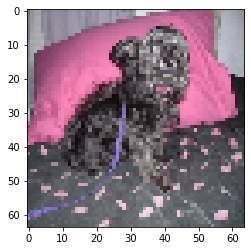

In [138]:
plt.imshow(scaled_DP[0, :, :, :])


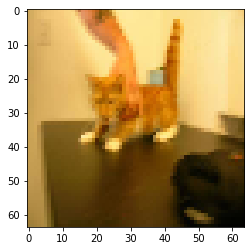

In [139]:
plt.imshow(scaled_CP[0, :, :, :])

## Combine the dogs and cats for grayscale and normal images (labels and images)  
    verify combination retrieves same photos by index

In [140]:
photos = np.append(scaled_CP, scaled_DP, axis=0)
#np.save('AssignmentTrainFeatures.npy', photos)
labels = np.append(catlabels, doglabels, axis=0)
#np.save('AssignmentTrainLables.npy',labels)
grayphotos= np.append(scaled_grayCats, scaled_grayDogs, axis =0)
#np.save('AssignmentGrayTrainFeatures.npy',grayphotos)

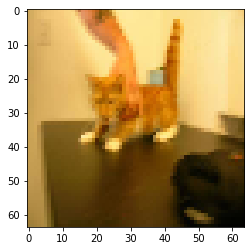

In [141]:
plt.imshow(photos[0, :, :, :])


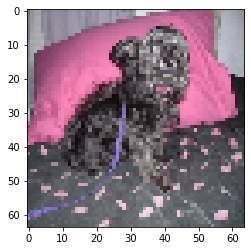

In [142]:
plt.imshow(photos[1000, :, :, :])


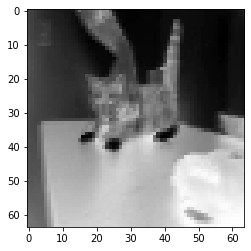

In [143]:
plt.imshow(grayphotos[0], cmap='gist_yarg')

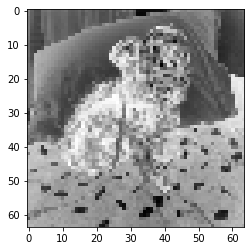

In [144]:
plt.imshow(grayphotos[1000], cmap='gist_yarg')

In [145]:
photos = np.load('AssignmentTrainFeatures.npy')
labels = np.load('AssignmentTrainLables.npy')
grayphotos= np.load('AssignmentGrayTrainFeatures.npy')

In [146]:
#shuffle the datasets so that we don't end up with vastly different proportions of cats/ dogs in validation and training sets.
X,  y = shuffle(photos, labels, random_state=RANDOM_SEED)

grayX, y = shuffle(grayphotos, labels, random_state=RANDOM_SEED)

In [147]:
#split the datasets into train and validation for grayscale and normal images.
trainX, valX, trainy, valy = train_test_split( X, y, test_size=0.40, random_state=RANDOM_SEED)
gray_trainX, gray_valX, gray_trainy, gray_valy  = train_test_split( grayX, y, test_size=0.40, random_state=RANDOM_SEED)

In [148]:
grayX.shape

(2000, 64, 64, 1)

scale = Pipeline([
        ('scaler', MinMaxScaler())
        ])
        
trainX = scale.fit_transform(trainX)
valX = scale.fit_transform(valX)

gray_trainX = scale.fit_transform(gray_trainX)
gray_valX = scale.fit_transform(gray_valX)

In [149]:
print(np.mean(trainy))
print(np.mean(valy))

0.49916666666666665
0.50125


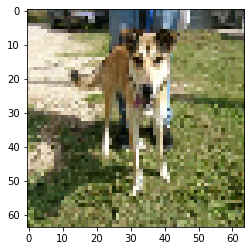

In [150]:
plt.imshow(trainX[1000])

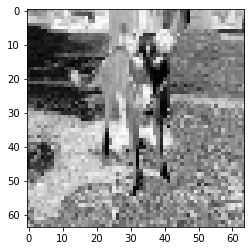

In [151]:
plt.imshow(gray_trainX[1000], cmap='gist_yarg')

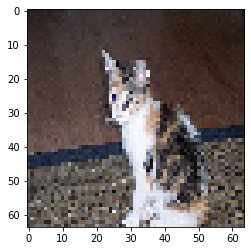

In [152]:
plt.imshow(valX[108])

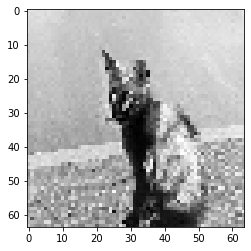

In [153]:
plt.imshow(gray_valX[108], cmap='gist_yarg')

## Prepare the test data for evaluation in 3 vs 1 channel (RGB vs grayscale)
    This is intentionally commented out to prevent disk writing and memory usage

In [154]:
#folder = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/test/'
#photos, grayphotos = list(), list()
        
#for file in os.listdir(folder):
	# load image and scale
#	photo = tf.keras.preprocessing.image.load_img(folder + file, target_size=(64, 64))

	# convert to numpy array
#	photo = tf.keras.preprocessing.image.img_to_array(photo)

	# append each scaled photo to photo list
#	photos.append(photo)

# convert list of arrays to array of arrays.
#photos = np.asarray(photos)

#print(photos.shape)

#save the reshaped photo array
#np.save('dogsNcatsTestFeatures.npy', photos)


In [155]:
#for file in os.listdir(folder):
	# load image and scale    
#    grayphoto = tf.keras.preprocessing.image.load_img(folder + file, color_mode='grayscale', target_size=(64, 64))
	# convert to numpy array

#    grayphoto = tf.keras.preprocessing.image.img_to_array(grayphoto)
    # append each scaled photo to photo list
#    grayphotos.append(grayphoto)
    
#convert list of arrays to array of arrays.
#grayphotos = np.asarray(grayphotos)

#print(grayphotos.shape)
#save the reshaped photo array
#np.save('dogsNcatsTestGrayFeatures.npy', grayphotos)

## Prepare the kaggle training set in RGB and Grayscale
    This is intentionally commented out to prevent disk writing and memory usage

In [156]:
#Generates loops over ana classifies images (1=dog, 0=cat), resizes to 100x100 pixels and stores labels and features as independant arrays
#folder = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/train/'
#Kgrayphotos = list()
        
#for file in os.listdir(folder):
	
#    grayphoto = tf.keras.preprocessing.image.load_img(folder + file, color_mode='grayscale', target_size=(64, 64))
	# convert to numpy array

#    grayphoto = tf.keras.preprocessing.image.img_to_array(grayphoto)
    # append each scaled photo to photo list
#    grayphotos.append(grayphoto)
	# store
#    Kgrayphotos.append(grayphoto)

                # convert to a numpy arrays
#Kgrayphotos = np.asarray(Kgrayphotos)

#print(Kgrayphotos.shape)
# save the reshaped photos
#np.save('KagglegrayTrainFeatures.npy', Kgrayphotos)


In [157]:
#photos, labels = list(), list()
        
#for file in os.listdir(folder):
	        # determine class
#	output = 0.0
#	if file.startswith('dog'):
#		output = 1.0
	        # load image
#	photo = tf.keras.preprocessing.image.load_img(folder + file, target_size=(64, 64))
	# convert to numpy array
#	photo = tf.keras.preprocessing.image.img_to_array(photo)
	# store
#	photos.append(photo)
#	labels.append(output)
                # convert to a numpy arrays
#photos = np.asarray(photos)
#labels = np.asarray(labels)
#print(photos.shape, labels.shape)
# save the reshaped photos
#np.save('KaggleTrainFeatures.npy', photos)
#np.save('KaggleTainLabels.npy', labels)

# Prepared Dataset Summary


In [158]:
dataSummary = {
    'ImageSource': ['Assignment Prompt', 'Assignment Prompt', 'Kaggle', 'Kaggle', 'Kaggle', 'Kaggle'], 
    'Train/Test':  ['Train', 'Train', 'Train','Train','Test','Test'],
    'ColorChannels': [3,1,3,1,3,1],
    'Totalbservations': [2000,2000,25000,25000,12500 ,12500 ],    
    'SavedArray': ['AssignmentTrainFeatures.npy' ,'AssignmentGrayTrainFeatures.npy' , 'KaggleTrainFeatures.npy', 'KagglegrayTrainFeatures.npy', 'dogsNcatsTestFeatures.npy' , 'dogsNcatsTestGrayFeatures.npy']
        }

dataSummary_df = pd.DataFrame.from_dict(dataSummary)
display(dataSummary_df)

,ImageSource,Train/Test,ColorChannels,Totalbservations,SavedArray
0,Assignment Prompt,Train,3,2000,AssignmentTrainFeatures.npy
1,Assignment Prompt,Train,1,2000,AssignmentGrayTrainFeatures.npy
2,Kaggle,Train,3,25000,KaggleTrainFeatures.npy
3,Kaggle,Train,1,25000,KagglegrayTrainFeatures.npy
4,Kaggle,Test,3,12500,dogsNcatsTestFeatures.npy
5,Kaggle,Test,1,12500,dogsNcatsTestGrayFeatures.npy


# 2) Model Construction, descriptions, and diagrams

## RGB Model

In [270]:
model = keras.models.Sequential()
#input convolutional layer
model.add(keras.layers.Conv2D(16, (8, 8),4, activation='relu', 
    padding='same', input_shape=(64, 64, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

#second convolutional and pooling layer with dropout
model.add(keras.layers.Conv2D(64, (4, 4),2, activation='relu',  padding='same',))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

#third convolutional layer with dropout
model.add(keras.layers.Conv2D(128, (3, 3),1, activation='relu',  padding='same',))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.5))

#flatten and fully connected layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
#output layer, binary response
model.add(keras.layers.Dense(1, activation='tanh'))

In [160]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 16, 16)        3088      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 64)          9280      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 2, 128)        

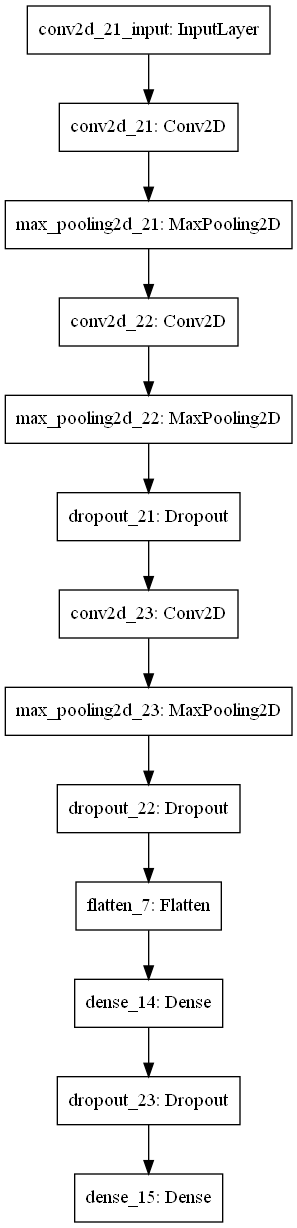

In [161]:
keras.utils.plot_model(model)

## Define optimizer and compile RGB model

In [271]:
#set the optimizer and compile
opt = tf.keras.optimizers.Adam(lr=0.000000001,  beta_1= 0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Grayscale model

gray_model = keras.models.Sequential()
#input convolutional layer
gray_model.add(keras.layers.Conv2D(16, (8, 8),4, activation='relu', 
    padding='same', input_shape=(64, 64, 1)))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))

#second convolutional and pooling layer with dropout
gray_model.add(keras.layers.Conv2D(64, (3, 3),1, activation='relu',  padding='same',))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))
gray_model.add(keras.layers.Dropout(0.2))

#third convolutional layer with dropout
gray_model.add(keras.layers.Conv2D(128, (3, 3),1, activation='relu',  padding='same',))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))
gray_model.add(keras.layers.Dropout(0.2))

#flatten and fully connected layer
gray_model.add(keras.layers.Flatten())
gray_model.add(keras.layers.Dense(128, activation='relu'))
gray_model.add(keras.layers.Dropout(0.5))
#output layer, binary response
gray_model.add(keras.layers.Dense(1, activation='tanh'))

In [164]:
gray_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 16, 16, 16)        1040      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 64)          9280      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 2, 2, 128)        

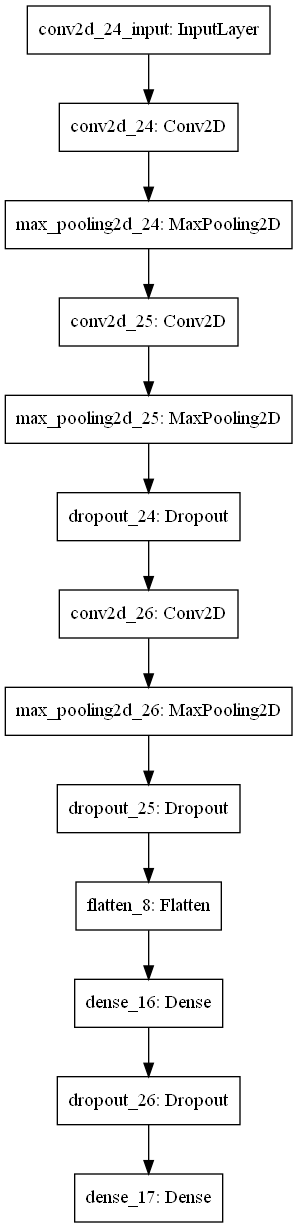

In [165]:
keras.utils.plot_model(gray_model)

In [269]:
opt = tf.keras.optimizers.Adam(lr=0.00000001,  beta_1= 0.)

gray_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 3) Assignment Prompt RGB images (Train and Predictions)

In [272]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)]

history = model.fit(trainX, trainy, epochs=100, callbacks=my_callbacks,
                    validation_data=(valX, valy))

Epoch 1/100
38/38 [==============================] - 1s 15ms/step - loss: 1.1374 - accuracy: 0.4928 - val_loss: 0.7117 - val_accuracy: 0.4925
Epoch 2/100
38/38 [==============================] - 0s 12ms/step - loss: 0.7348 - accuracy: 0.5040 - val_loss: 0.7383 - val_accuracy: 0.4988
Epoch 3/100
38/38 [==============================] - 0s 11ms/step - loss: 0.7239 - accuracy: 0.5087 - val_loss: 0.6906 - val_accuracy: 0.5088
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.5340 - val_loss: 0.7323 - val_accuracy: 0.4975
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 0.6956 - accuracy: 0.5588 - val_loss: 0.6851 - val_accuracy: 0.5587
Epoch 6/100
38/38 [==============================] - 0s 12ms/step - loss: 0.6908 - accuracy: 0.5276 - val_loss: 0.6843 - val_accuracy: 0.5400
Epoch 7/100
38/38 [==============================] - 0s 13ms/step - loss: 0.6943 - accuracy: 0.5432 - val_loss: 0.6756 - val_accuracy: 0.5813
Epoch 

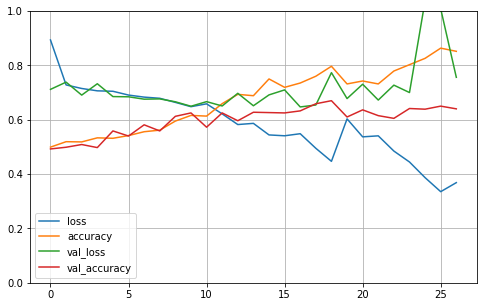

In [273]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [274]:
As_RGBTrainingPreds = model.predict_classes(trainX)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

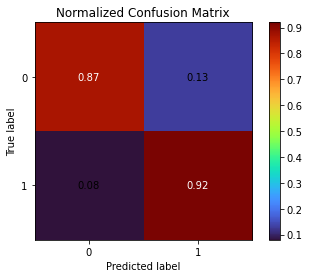

In [275]:
skplt.metrics.plot_confusion_matrix(trainy, As_RGBTrainingPreds, normalize=True, cmap='turbo')

In [277]:
TestFeatures = np.load('dogsNcatsTestFeatures.npy')


In [278]:
As_RGB_TestPreds = model.predict_classes(TestFeatures)
As_RGB_TestLabels = As_RGB_TestPreds.tolist()
As_RGB_TestLabels = [item for sublist in As_RGB_TestLabels for item in sublist]
ImageId = np.linspace(1,len(As_RGB_TestLabels),len(As_RGB_TestLabels))
labels = pd.DataFrame({"id": ImageId, "label": As_RGB_TestLabels})
labels.to_csv('As_RGB_TestPreds.csv', index=False)

# 4) Assignment Prompt grayscale images (Train and Predictions)

In [173]:
gray_history = gray_model.fit(gray_trainX, gray_trainy, epochs=100, callbacks=my_callbacks,
                    validation_data=(gray_valX, gray_valy))

Epoch 1/100
38/38 [==============================] - 1s 17ms/step - loss: 1.1361 - accuracy: 0.5251 - val_loss: 0.6854 - val_accuracy: 0.5888
Epoch 2/100
38/38 [==============================] - 1s 18ms/step - loss: 0.7009 - accuracy: 0.5531 - val_loss: 0.6844 - val_accuracy: 0.5487
Epoch 3/100
38/38 [==============================] - 1s 14ms/step - loss: 0.6897 - accuracy: 0.5409 - val_loss: 0.6866 - val_accuracy: 0.5425
Epoch 4/100
38/38 [==============================] - 0s 13ms/step - loss: 0.6816 - accuracy: 0.5768 - val_loss: 0.6943 - val_accuracy: 0.5300
Epoch 5/100
38/38 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.5510 - val_loss: 0.6853 - val_accuracy: 0.5450
Epoch 6/100
38/38 [==============================] - 1s 14ms/step - loss: 0.6941 - accuracy: 0.5645 - val_loss: 0.6946 - val_accuracy: 0.5200
Epoch 7/100
38/38 [==============================] - 1s 14ms/step - loss: 0.6901 - accuracy: 0.5656 - val_loss: 0.6739 - val_accuracy: 0.5900
Epoch 

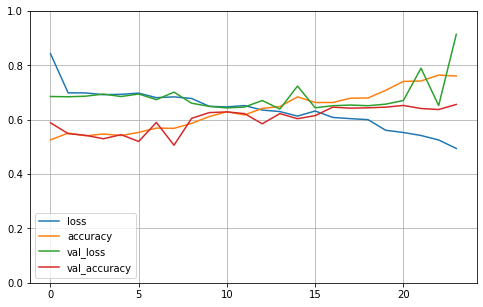

In [174]:
pd.DataFrame(gray_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# 5) Kaggle competition RGB images (Train and Predictions)

In [279]:
photos = np.load('KaggleTrainFeatures.npy')
labels = np.load('KaggleTainLabels.npy')

print(photos.shape)
print(labels.shape)

(25000, 64, 64, 3)
(25000,)


'KaggleTrainFeatures.npy', 'KagglegrayTrainFeatures.npy'

In [280]:
X,  y = shuffle(photos, labels, random_state=RANDOM_SEED)
trainX, valX, trainy, valy = train_test_split( X, y, test_size=0.40, random_state=RANDOM_SEED)

In [289]:
model = keras.models.Sequential()
#input convolutional layer
model.add(keras.layers.Conv2D(32, (3, 3),2, activation='relu', 
    padding='same', input_shape=(64, 64, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

#second convolutional and pooling layer with dropout
model.add(keras.layers.Conv2D(64, (3, 3),1, activation='relu',  padding='same',))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

#third convolutional layer with dropout
model.add(keras.layers.Conv2D(128, (3, 3),1, activation='relu',  padding='same',))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.5))

#flatten and fully connected layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
#output layer, binary response
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [290]:
#set the optimizer and compile
opt = tf.keras.optimizers.SGD(lr=0.001,  momentum= 0.01)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [291]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)]

history = model.fit(trainX, trainy, epochs=100, callbacks=my_callbacks,
                    validation_data=(valX, valy))

Epoch 1/100
469/469 [==============================] - 20s 42ms/step - loss: 3.1999 - accuracy: 0.5089 - val_loss: 0.6877 - val_accuracy: 0.5593
Epoch 2/100
469/469 [==============================] - 19s 41ms/step - loss: 0.7042 - accuracy: 0.5187 - val_loss: 0.6882 - val_accuracy: 0.5645
Epoch 3/100
469/469 [==============================] - 19s 42ms/step - loss: 0.6974 - accuracy: 0.5203 - val_loss: 0.6882 - val_accuracy: 0.5605
Epoch 4/100
469/469 [==============================] - 20s 42ms/step - loss: 0.6948 - accuracy: 0.5273 - val_loss: 0.6863 - val_accuracy: 0.5888
Epoch 5/100
469/469 [==============================] - 19s 41ms/step - loss: 0.6911 - accuracy: 0.5386 - val_loss: 0.6848 - val_accuracy: 0.5947
Epoch 6/100
469/469 [==============================] - 19s 41ms/step - loss: 0.6876 - accuracy: 0.5557 - val_loss: 0.6841 - val_accuracy: 0.6053
Epoch 7/100
469/469 [==============================] - 20s 43ms/step - loss: 0.6850 - accuracy: 0.5591 - val_loss: 0.6824 - val_ac

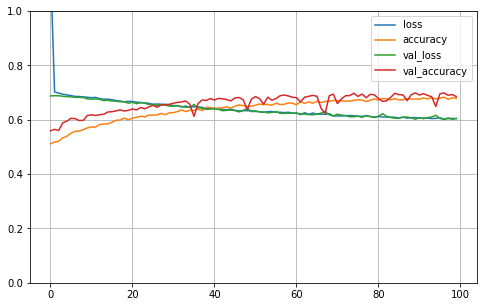

In [292]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

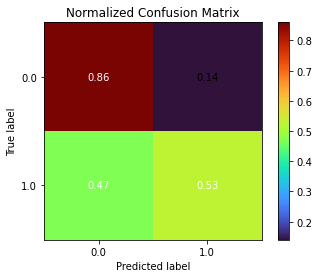

In [296]:
Kg_RGBTrainingPreds = model.predict_classes(trainX)
skplt.metrics.plot_confusion_matrix(trainy, Kg_RGBTrainingPreds, normalize=True, cmap='turbo')

In [297]:
Kg_RGB_TestPreds = model.predict_classes(TestFeatures)
Kg_RGB_TestLabels = Kg_RGB_TestPreds.tolist()
Kg_RGB_TestLabels = [item for sublist in Kg_RGB_TestLabels for item in sublist]
ImageId = np.linspace(1,len(Kg_RGB_TestLabels),len(Kg_RGB_TestLabels))
labels = pd.DataFrame({"id": ImageId, "label": Kg_RGB_TestLabels})
labels.to_csv('Kg_RGB_TestPreds.csv', index=False)